## D(st)reams of Anomaly

#### The Numenta Anomaly Benchmark (NAB) is a novel benchmark for evaluating algorithms for anomaly detection in streaming, online applications. It is comprised of over 50 labeled real-world and artificial timeseries data files plus a novel scoring mechanism designed for real-time applications.

#### Data source : https://www.kaggle.com/boltzmannbrain/nab

#### I've applied anomaly detecting model on realKnownCause dataset "machine_temperature_system_failure.csv"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from datetime import datetime

from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import axes3d, Axes3D 
warnings.filterwarnings('ignore')

In [2]:
dataframe=pd.read_csv("../data/external/machine_temperature_system_failure.csv")
dataframe.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [4]:
dataframe.dtypes

timestamp     object
value        float64
dtype: object

In [5]:
#dataframe['timestamp']=pd.to_datetime(dataframe['timestamp'])

In [6]:
dataframe.dtypes

timestamp     object
value        float64
dtype: object

#### checking if there is any null data

In [7]:
dataframe.isnull().sum()

timestamp    0
value        0
dtype: int64

#### checking if there are any duplicated rows

In [8]:
duplicateRows = dataframe[dataframe.duplicated(['timestamp','value'])]
duplicateRows.head()

,timestamp,value


### Data Visulalization

#### Temperature ranging

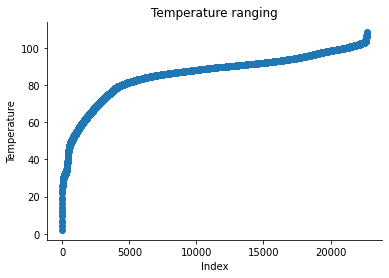

In [9]:
plt.scatter(dataframe.index, np.sort(dataframe['value'].values))
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title("Temperature ranging")
sns.despine()

## Feature Engineering

#### Generated year,day,hour,day of the week,month,week number,time of day and season from timestmap

In [10]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).year
dataframe['year'] = dataframe['timestamp'].map(year)
day = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).day
dataframe['day'] = dataframe['timestamp'].map(day)
hour = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).hour
dataframe['hour'] = dataframe['timestamp'].map(hour)

In [11]:
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).weekday()
dataframe['day_of_week'] = dataframe['timestamp'].map(day_of_week)
month = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month
dataframe['month'] = dataframe['timestamp'].map(month)
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).strftime('%V')
dataframe['week_number'] = dataframe['timestamp'].map(week_number)

#### December-February  is considered as Winter season ; March-May is considered as Spring ; June-August is considered as Summer ; September - August is considered as Fall

In [12]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0]
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d %H:%M:%S" ).month-1)]
dataframe['season'] = dataframe['timestamp'].map(season)

#### sleep is indicated with value '0': timeslot: 12-5 ;  Timeslot: 6-9: breakfast time is indicated with value 1 ;timeslot:10-14: lunch, is indicated with value 2 ; timeslot:14-17: dinner preparation time is indicated with value 3, timeslot:17-21: dinner time is indicated with value 4; timeslot:21-23(5): light snack time is indicated with value 5

In [13]:
times_of_day = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5 ]
time_of_day = lambda x: times_of_day[datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour]
dataframe['time_of_day'] = dataframe['timestamp'].map(time_of_day)

In [14]:
dataframe.head()

,timestamp,value,year,day,hour,day_of_week,month,week_number,season,time_of_day
0,2013-12-02 21:15:00,73.967322,2013,2,21,0,12,49,0,5
1,2013-12-02 21:20:00,74.935882,2013,2,21,0,12,49,0,5
2,2013-12-02 21:25:00,76.124162,2013,2,21,0,12,49,0,5
3,2013-12-02 21:30:00,78.140707,2013,2,21,0,12,49,0,5
4,2013-12-02 21:35:00,79.329836,2013,2,21,0,12,49,0,5


## Modeling

## Anomoly detection using Isolation forest

In [15]:
data = dataframe[['value','day', 'day_of_week']]
from sklearn.ensemble import IsolationForest
clf=IsolationForest( n_estimators=100, max_samples='auto', contamination=0.05, \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(data[data.columns])
pred = clf.predict(data[data.columns])
data['anomaly']=pred
outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)
data['anomaly'] = data['anomaly'].map( {1: 0, -1: 1} )
print(data['anomaly'].value_counts())

0    21561
1     1134
Name: anomaly, dtype: int64


#### Visualization

#### Converting 'timestamp' data type to datetime format

In [16]:
dataframe['timestamp']=pd.to_datetime(dataframe['timestamp'])

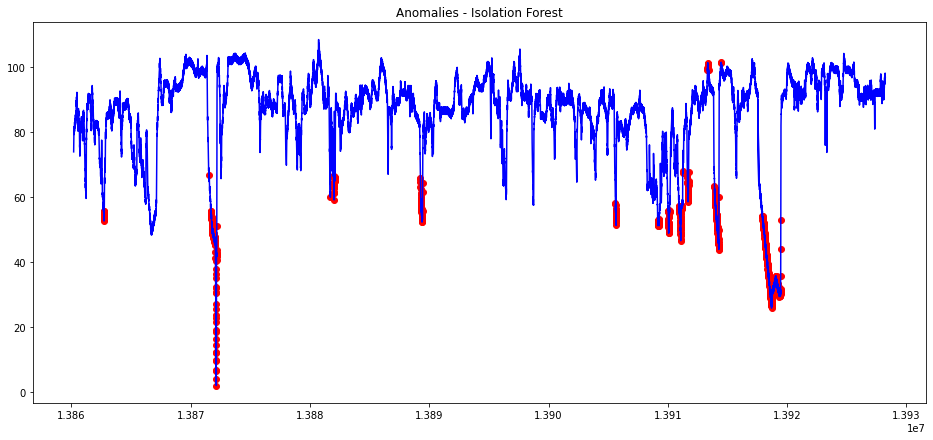

In [17]:
fig, ax = plt.subplots()

dataframe['Time'] = (dataframe['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = dataframe.loc[data['anomaly'] == 1, ['Time', 'value']] 

fig.set_size_inches(16,7)
ax.plot(dataframe['Time'], dataframe['value'], color='blue')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - Isolation Forest")
plt.show()

#### visualisation of anomaly with temperature repartition

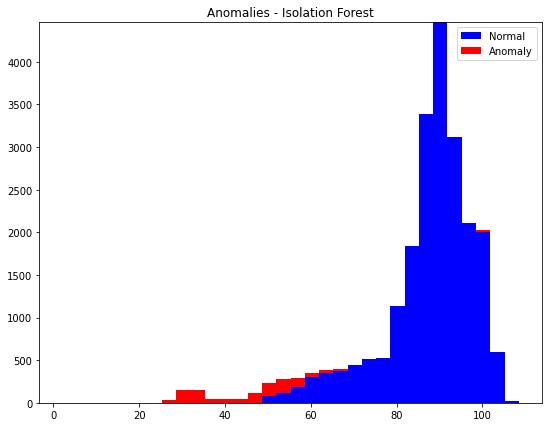

In [18]:
a = dataframe.loc[data['anomaly'] == 0, 'value']
b = dataframe.loc[data['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

#### Visualizing Anomoly in 3D

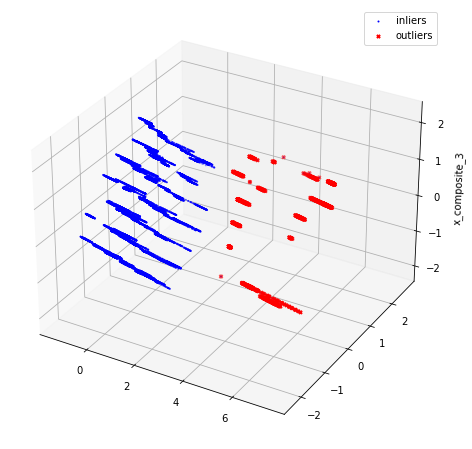

In [19]:
pca = PCA(n_components=3) 
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[data.columns])
model = pca.fit_transform(np_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(model[:, 0], model[:, 1], zs=model[:, 2], s=1, lw=1, label="inliers",c="blue")
ax.scatter(model[outlier_index,0],model[outlier_index,1], model[outlier_index,2],lw=2, s=10, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

#### Anomoly detection using SVM model

In [20]:
from sklearn.svm import OneClassSVM
data = dataframe[['value','day', 'day_of_week']]
clf=OneClassSVM(nu=0.95 * 0.05)
clf.fit(data[data.columns])
pred = clf.predict(data[data.columns])
data['anomaly']=pred
outliers=data.loc[data['anomaly']==-1]
outlier_index=list(outliers.index)
data['anomaly'] = data['anomaly'].map( {1: 0, -1: 1} )
print(data['anomaly'].value_counts())

0    21617
1     1078
Name: anomaly, dtype: int64


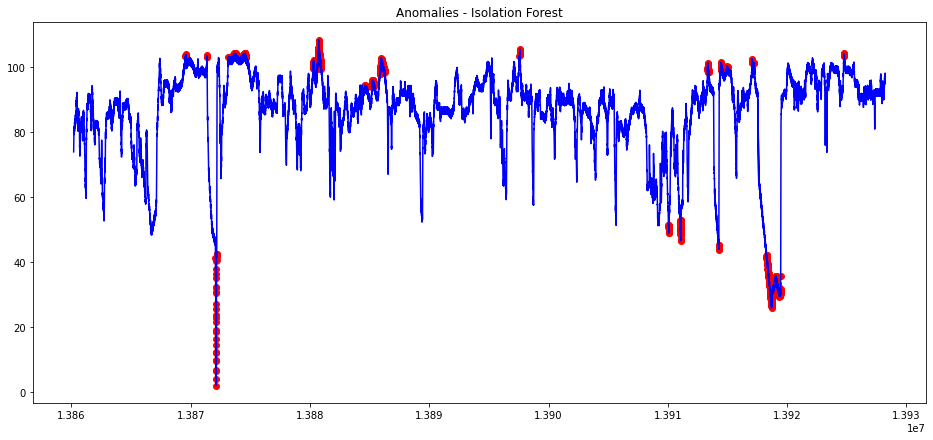

In [21]:
fig, ax = plt.subplots()

dataframe['Time'] = (dataframe['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

a = dataframe.loc[data['anomaly'] == 1, ['Time', 'value']] 

fig.set_size_inches(16,7)
ax.plot(dataframe['Time'], dataframe['value'], color='blue')
ax.scatter(a['Time'],a['value'], color='red')
plt.title("Anomalies - Isolation Forest")
plt.show()

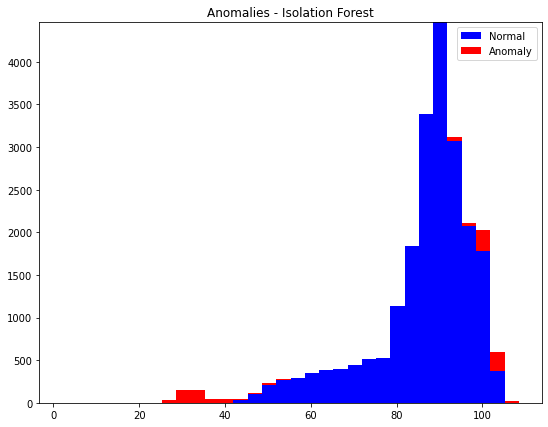

In [22]:
a = dataframe.loc[data['anomaly'] == 0, 'value']
b = dataframe.loc[data['anomaly'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['Normal', 'Anomaly'])
fig.set_size_inches(9,7)
plt.title("Anomalies - Isolation Forest")
plt.legend()
plt.show()

#### Visulazing in 3D

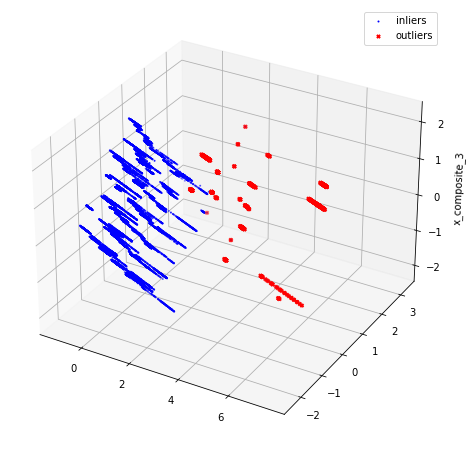

In [23]:
pca = PCA(n_components=3) 
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(data[data.columns])
model = pca.fit_transform(np_scaled)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
ax.scatter(model[:, 0], model[:, 1], zs=model[:, 2], s=1, lw=1, label="inliers",c="blue")
ax.scatter(model[outlier_index,0],model[outlier_index,1], model[outlier_index,2],
           lw=2, s=10, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

#### checking the distribution of temperature pattern over the years

<AxesSubplot:xlabel='timestamp'>

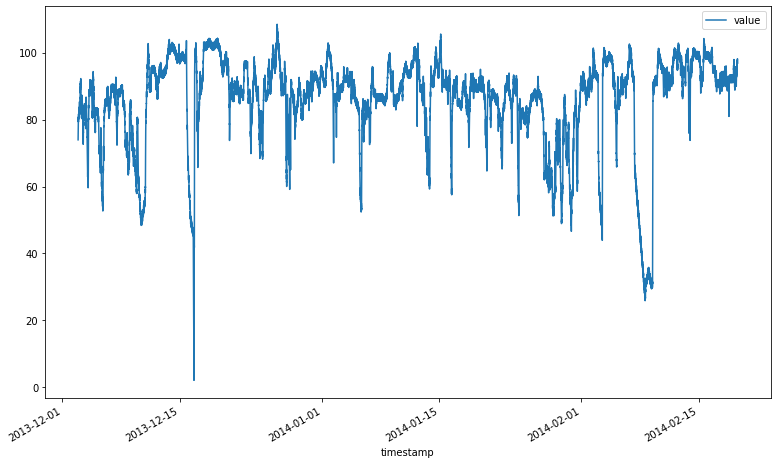

In [24]:
dataframe.plot(x='timestamp', y='value', figsize=(13,8))

## Observations

#### 1. As we can see One class SVM performed well than Isolation forest
#### From graphs we can also say that system failure has occuring
###### . First anomoly has occured during third week of December in 2015.
###### . Second anomoly  and third anomoly has occured during second week of Januray in 2014.